In [26]:
%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import shap

import warnings
warnings.filterwarnings("ignore")

#Set random seed to current date and time to get a pseudorandom state
import random
from datetime import datetime
random.seed(datetime.now()) 

#This is to round the output to 3 decimal places when printing outputs
np.set_printoptions(precision=3)

#Import dataset
data = pd.read_csv("C:/Users/kimng/Desktop/ML - Age, Hipp, CVLT/CVLTHippocampus.csv")
data = data.reset_index(drop=True)

In [27]:
#Select columns to be used for analyses
columns = ['CVLT_Imm_Total', 'CVLT_DelR_SD_Free', 'CVLT_DelR_LD_Free',
            'Age','Sex', 'EduYears', 'Smoker', 'High_BP', 'COMT', 'BDNF2', 'ApoE4',
           'L_HH_Total', 'R_HH_Total', 'L_HB_Total', 'R_HB_Total', 'L_HT_Total', 'R_HT_Total',
           'L_DG_Total', 'R_DG_Total',
           'L_CA_Total', 'R_CA_Total',
           'L_Sub_Total', 'R_Sub_Total',
           'L_HH_CA', 'R_HH_CA', 'L_HB_CA', 'R_HB_CA', 'L_HT_CA', 'R_HT_CA', 
           'L_HH_DG', 'R_HH_DG', 'L_HB_DG', 'R_HB_DG', 'L_HT_DG', 'R_HT_DG',
           'L_HH_Sub', 'R_HH_Sub', 'L_HB_Sub', 'R_HB_Sub', 'L_HT_Sub', 'R_HT_Sub']

#Subset data
df = data[columns]

In [28]:
#check if there were any missing data
df.isnull().sum()

CVLT_Imm_Total        3
CVLT_DelR_SD_Free     3
CVLT_DelR_LD_Free     3
Age                   0
Sex                   0
EduYears              0
Smoker                0
High_BP               0
COMT                  0
BDNF2                 0
ApoE4                 0
L_HH_Total           11
R_HH_Total           11
L_HB_Total           11
R_HB_Total           11
L_HT_Total           11
R_HT_Total           11
L_DG_Total           11
R_DG_Total           11
L_CA_Total           11
R_CA_Total           11
L_Sub_Total          11
R_Sub_Total          11
L_HH_CA              11
R_HH_CA              11
L_HB_CA              11
R_HB_CA              11
L_HT_CA              11
R_HT_CA              11
L_HH_DG              11
R_HH_DG              11
L_HB_DG              11
R_HB_DG              11
L_HT_DG              11
R_HT_DG              11
L_HH_Sub             11
R_HH_Sub             11
L_HB_Sub             11
R_HB_Sub             11
L_HT_Sub             11
R_HT_Sub             11
dtype: int64

In [29]:
# drop missing data list-wise
df.dropna(inplace=True)

#reset index -- this is to replace old data index with index based on current data.
df = df.reset_index(drop=True)

# get new data dimension
df.shape 

(129, 41)

In [30]:
df.Sex = df.Sex-1 #Change Sex from 1,2 to 0,1

In [31]:
#Bin Age into groups
bins = [10, 20, 30, 40, 50, 60, 70, 80, 90]
labels = [1,2,3,4,5,6,7,8]
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels)
df = df.reset_index(drop=True)

#Function for categorise dataframe
def categorise(row):
    if row['AgeGroup'] == 1 and row['Sex'] == 0:
        return 1
    elif row['AgeGroup'] == 1 and row['Sex'] == 1:
        return 2
    elif row['AgeGroup'] == 2 and row['Sex'] == 0:
        return 3
    elif row['AgeGroup'] == 2 and row['Sex'] == 1:
        return 4
    elif row['AgeGroup'] == 3 and row['Sex'] == 0:
        return 5
    elif row['AgeGroup'] == 3 and row['Sex'] == 1:
        return 6
    elif row['AgeGroup'] == 4 and row['Sex'] == 0:
        return 7
    elif row['AgeGroup'] == 4 and row['Sex'] == 1:
        return 8
    elif row['AgeGroup'] == 5 and row['Sex'] == 0:
        return 9
    elif row['AgeGroup'] == 5 and row['Sex'] == 1:
        return 10
    elif row['AgeGroup'] == 6 and row['Sex'] == 0:
        return 11
    elif row['AgeGroup'] == 6 and row['Sex'] == 1:
        return 12
    elif row['AgeGroup'] == 7 and row['Sex'] == 0:
        return 13
    elif row['AgeGroup'] == 7 and row['Sex'] == 1:
        return 14
    elif row['AgeGroup'] == 8 and row['Sex'] == 0:
        return 15
    elif row['AgeGroup'] == 8 and row['Sex'] == 1:
        return 16


#Apply categories to dataframe
df['grp'] = df.apply(lambda row: categorise(row), axis=1)

In [32]:
df.describe()

,CVLT_Imm_Total,CVLT_DelR_SD_Free,CVLT_DelR_LD_Free,Age,Sex,EduYears,Smoker,High_BP,COMT,BDNF2,...,R_HB_DG,L_HT_DG,R_HT_DG,L_HH_Sub,R_HH_Sub,L_HB_Sub,R_HB_Sub,L_HT_Sub,R_HT_Sub,grp
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,...,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,54.775194,11.666667,12.248062,47.635659,0.542636,15.860465,1.031008,1.116279,2.062016,1.666667,...,312.167117,215.278658,216.086355,270.114788,286.853054,216.401042,208.797596,26.868606,29.594662,8.054264
std,9.126062,2.608080,2.613161,18.883251,0.500121,2.461403,0.174014,0.321809,0.736885,0.473242,...,56.639130,55.946779,57.863672,54.831992,53.460985,41.213681,35.336911,6.789627,8.055470,3.863511
min,35.000000,6.000000,5.000000,18.000000,0.000000,10.000000,1.000000,1.000000,1.000000,1.000000,...,173.639405,89.231806,89.795907,148.819290,158.846793,110.909966,106.781205,12.233782,15.553328,1.000000
25%,49.000000,10.000000,10.000000,30.000000,0.000000,14.000000,1.000000,1.000000,2.000000,1.000000,...,271.435985,174.712057,181.698029,229.770510,254.843688,186.129439,187.518921,22.200925,24.290453,4.000000
50%,55.000000,12.000000,12.000000,48.000000,1.000000,16.000000,1.000000,1.000000,2.000000,2.000000,...,313.215662,213.735190,209.295573,265.785139,285.320587,215.537167,209.140882,24.817369,28.900795,8.000000
75%,61.000000,14.000000,14.000000,64.000000,1.000000,17.000000,1.000000,1.000000,3.000000,2.000000,...,349.277249,254.920021,254.615139,310.839873,317.390520,243.406118,230.304132,31.469792,33.466886,11.000000
max,73.000000,16.000000,16.000000,85.000000,1.000000,23.000000,2.000000,2.000000,3.000000,2.000000,...,455.998451,352.813403,363.037216,433.877967,494.619458,332.358149,305.395180,46.911832,55.632057,16.000000


In [33]:
#Initialize Regressor
model = RandomForestRegressor()

#Set up parameter grid
param_grid = [{'criterion': ['squared_error'], 
                'max_depth': [5, 6, 7, 8, 9, 10, 15, 20],
                'min_samples_leaf': [5, 10, 15, 20],
                'n_estimators': [10, 20, 30, 40, 50]}]

#Set up GridSearchCV
search = GridSearchCV(estimator=model, 
                      param_grid = param_grid,
                      scoring = 'neg_mean_squared_error', #use MSE for model selection (larger neg-MSE = better model)
                      cv = 3, 
                      n_jobs = 1, 
                      refit = True)

<IPython.core.display.Javascript object>


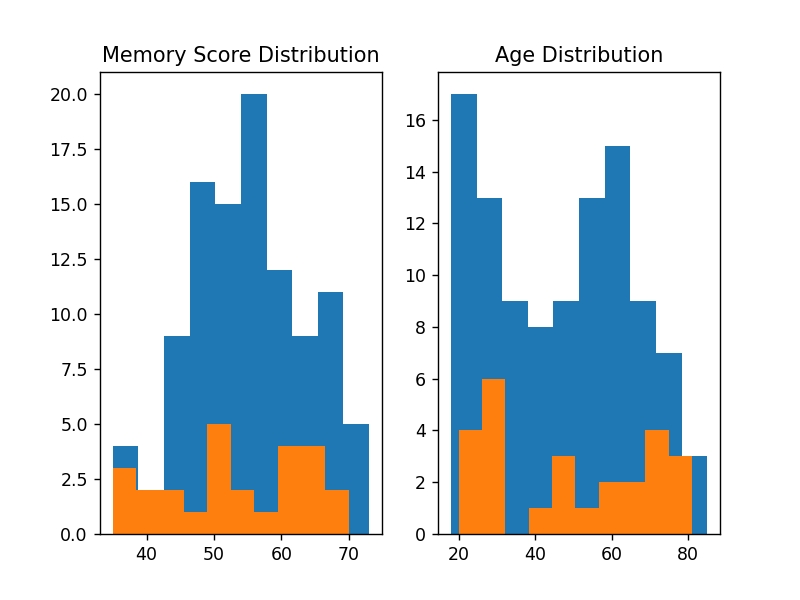


 Results for outer loop fold 1
        Best MSE (inner validation folds): 64.37452727138664
        Best parameters: {'criterion': 'squared_error', 'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 10}
        MSE (on outer training fold) 26.054808244293987
        MSE (on outer test fold) 89.83422935089
        RMSE (on outer test fold) 9.478092073349467
        MAE (on outer test fold) 7.999607383566657
        R2 (on outer validation fold) 0.1818839127402816
        Predicted vs actual values correlation (on outer test fold) 0.45851921041567567


<IPython.core.display.Javascript object>


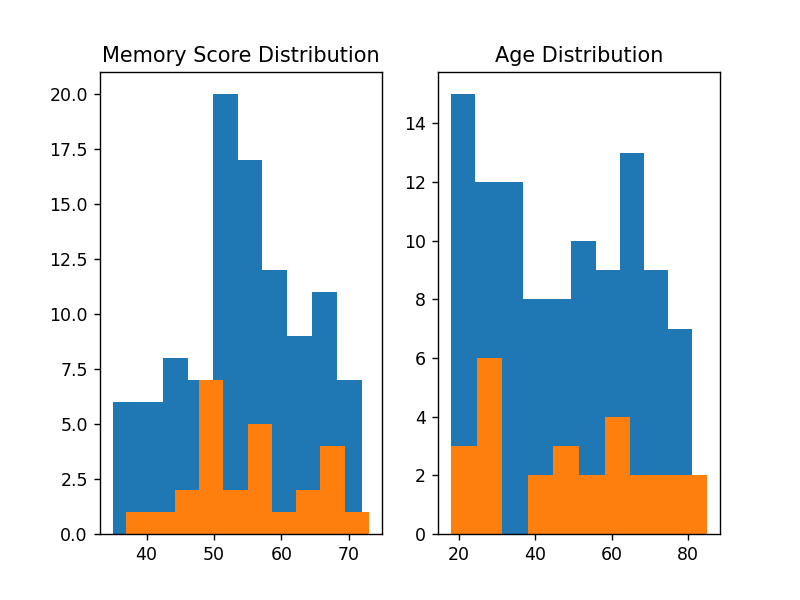


 Results for outer loop fold 2
        Best MSE (inner validation folds): 68.51573152568118
        Best parameters: {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 10}
        MSE (on outer training fold) 46.709837863847824
        MSE (on outer test fold) 47.901744731373995
        RMSE (on outer test fold) 6.921108634559495
        MAE (on outer test fold) 5.23624051914643
        R2 (on outer validation fold) 0.3793303028749363
        Predicted vs actual values correlation (on outer test fold) 0.7054735651701138


<IPython.core.display.Javascript object>


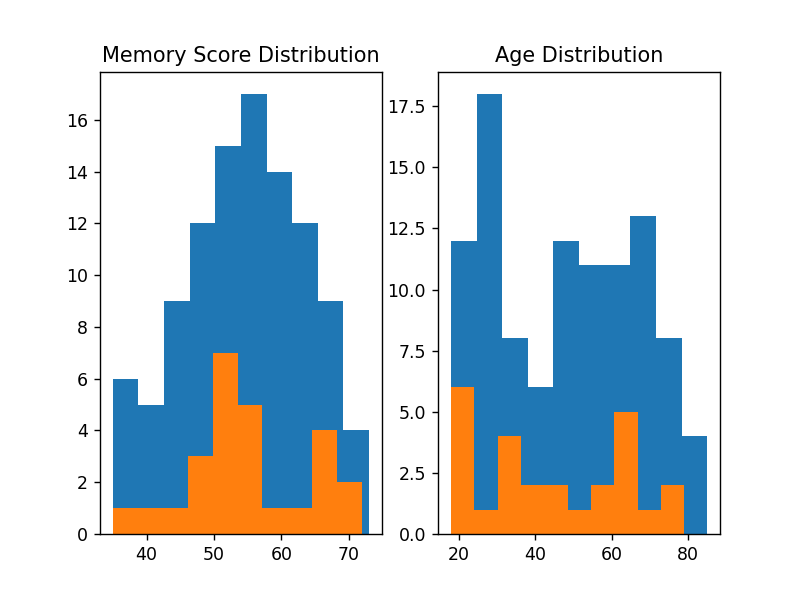


 Results for outer loop fold 3
        Best MSE (inner validation folds): 65.03653694713749
        Best parameters: {'criterion': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 5, 'n_estimators': 30}
        MSE (on outer training fold) 24.8535638215744
        MSE (on outer test fold) 75.27523193534968
        RMSE (on outer test fold) 8.676130009131358
        MAE (on outer test fold) 7.279798338497434
        R2 (on outer validation fold) 0.1032977939610844
        Predicted vs actual values correlation (on outer test fold) 0.3397533758431189


<IPython.core.display.Javascript object>


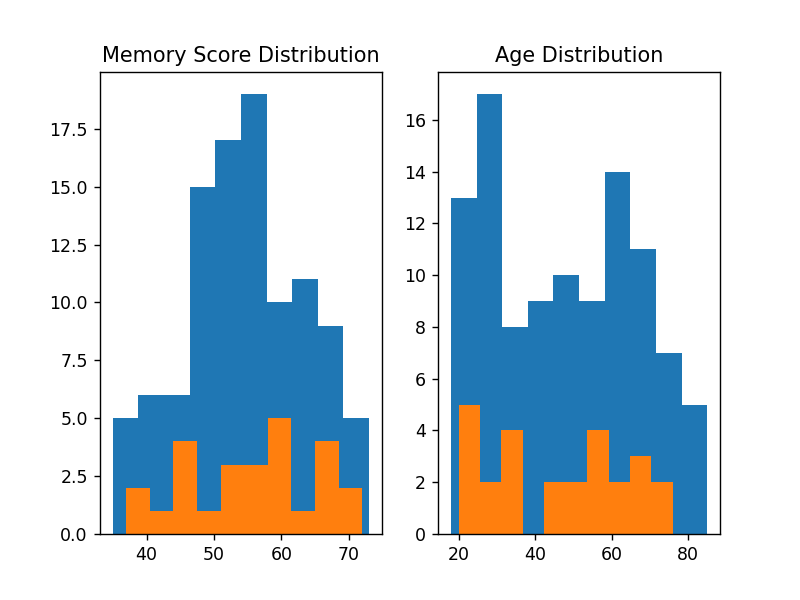


 Results for outer loop fold 4
        Best MSE (inner validation folds): 59.68520968139407
        Best parameters: {'criterion': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 5, 'n_estimators': 20}
        MSE (on outer training fold) 22.667728020963818
        MSE (on outer test fold) 85.16984019374483
        RMSE (on outer test fold) 9.228750738520617
        MAE (on outer test fold) 7.35782897927203
        R2 (on outer validation fold) 0.052001185994903776
        Predicted vs actual values correlation (on outer test fold) 0.2812731315515624


<IPython.core.display.Javascript object>


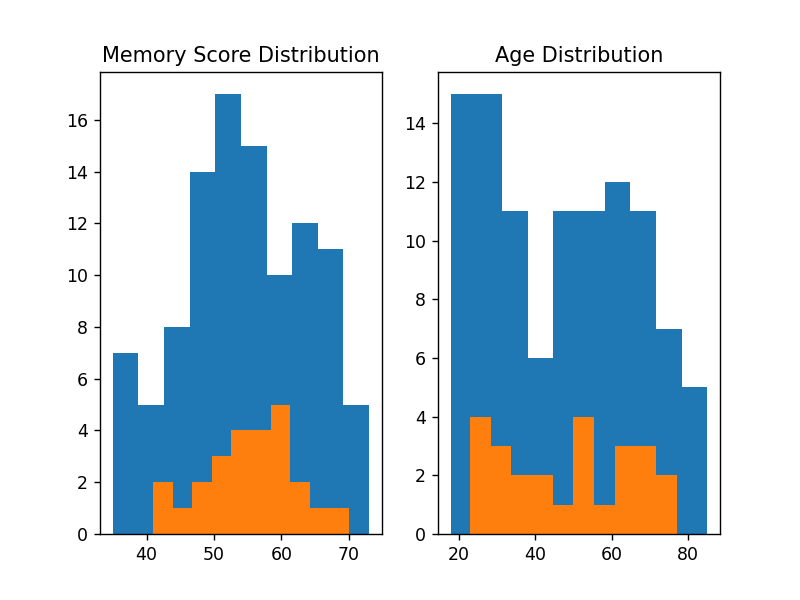


 Results for outer loop fold 5
        Best MSE (inner validation folds): 75.65297917005988
        Best parameters: {'criterion': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 15, 'n_estimators': 10}
        MSE (on outer training fold) 58.21890238237852
        MSE (on outer test fold) 51.9066688160534
        RMSE (on outer test fold) 7.204628291317561
        MAE (on outer test fold) 6.151641041206115
        R2 (on outer validation fold) -0.10661986662687184
        Predicted vs actual values correlation (on outer test fold) 0.148229335458028

    Average performance across all outer loops:
        MSE 70.02 +/- 17.13
        RMSE 8.30 +/- 1.05
        MAE 6.81 +/- 0.98
        R2 0.12 +/- 0.16
        Correlation 0.39 +/- 0.19


In [89]:
# Empty list to store evaluation metrics
outer_scores_mae = []
outer_scores_mse = []
outer_scores_rmse = []
outer_scores_corelation = []
outer_scores_r2 = []

# configure the cross-validation procedure
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) 

#fold counter
fold_no = 1

# Loop through each outer CV fold
for train_index_outer, test_index_outer in outer_cv.split(df, df.grp):
    train_set = df.loc[train_index_outer,:]
    test_set = df.loc[test_index_outer,:]

    feature_names = ['Age','Sex', 'EduYears', 'Smoker', 'High_BP', 'COMT', 'BDNF2', 'ApoE4',
                     'L_HH_Total', 'R_HH_Total', 'L_HB_Total', 'R_HB_Total', 'L_HT_Total', 'R_HT_Total',
                     'L_DG_Total', 'R_DG_Total',
                     'L_CA_Total', 'R_CA_Total',
                     'L_Sub_Total', 'R_Sub_Total',
                     'L_HH_CA', 'R_HH_CA', 'L_HB_CA', 'R_HB_CA', 'L_HT_CA', 'R_HT_CA', 
                     'L_HH_DG', 'R_HH_DG', 'L_HB_DG', 'R_HB_DG', 'L_HT_DG', 'R_HT_DG',
                     'L_HH_Sub', 'R_HH_Sub', 'L_HB_Sub', 'R_HB_Sub', 'L_HT_Sub', 'R_HT_Sub']
    target = ['CVLT_Imm_Total']

    X_train = train_set[feature_names]
    y_train = train_set[target]
    X_test = test_set[feature_names]
    y_test = test_set[target]
    
        
    print("\n Results for outer loop fold", fold_no)
    fold_no = fold_no+1
        
    
    #Print out memory performance to ensure similar distribution across folds
    plt.figure()
    plt.subplot(1, 2, 1) 
    plt.hist(y_train, bins=10)
    plt.hist(y_test, bins=10)
    plt.title("Memory Score Distribution")
    
    plt.subplot(1, 2, 2)
    plt.hist(X_train.Age, bins=10)
    plt.hist(X_test.Age, bins=10)
    plt.title("Age Distribution")
    
    plt.show()
    
    #Apply grid search with CV=3 on outer train_set (this is hyperparameter tuning process within the inner loop)
    search.fit(X = X_train, y = y_train) # run inner loop hyperparam tuning

    print('        Best MSE (inner validation folds):', abs(search.best_score_))
    print('        Best parameters:', search.best_params_)
    
    #Best model based on grid search
    best_model = search.best_estimator_
   
    #Inner Train set performance
    #This is to compare with performance on the test set and identify fitting issues
    y_train_hat = best_model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_hat)
    print('        MSE (on outer training fold)', mse_train)
    
    #Predict y_test based on best model
    y_test_hat = best_model.predict(X_test)
    
    # Calculate evaluation metrics using best-tuned model on the outer val_set  
    #MSE
    mse_test = mean_squared_error(y_test, y_test_hat)
    outer_scores_mse.append(mse_test)
    print('        MSE (on outer test fold)', (outer_scores_mse[-1]))
    
    #RMSE
    rmse_test = np.sqrt(mse_test)
    outer_scores_rmse.append(rmse_test)
    print('        RMSE (on outer test fold)', (outer_scores_rmse[-1]))

    # MAE
    mae_test = mean_absolute_error(y_test, y_test_hat)
    outer_scores_mae.append(mae_test)          
    print('        MAE (on outer test fold)', (outer_scores_mae[-1]))
         
    # R2
    r2_test = r2_score(y_test, y_test_hat)
    outer_scores_r2.append(r2_test)    
    print('        R2 (on outer validation fold)', (outer_scores_r2[-1]))
    
    #Correlation between true vs predicted
    y_test_array = np.array(y_test).reshape(1,len(y_test))
    y_test_hat_array = pd.DataFrame(y_test_hat)
    y_test_hat_array = np.array(y_test_hat_array).reshape(1,len(y_test_hat))
    corelation_true_pred = np.corrcoef(y_test_array, y_test_hat_array)[0,1]
    outer_scores_corelation.append(corelation_true_pred)          
    print('        Predicted vs actual values correlation (on outer test fold)', (outer_scores_corelation[-1]))
    
    #explain all the predictions in the test set
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_val)
    print(shap_values)

# Print evaluation metrics across all outer loop folds
print('\n    Average performance across all outer loops:')
print('        MSE %.2f +/- %.2f'% (np.mean(outer_scores_mse), np.std(outer_scores_mse)))
print('        RMSE %.2f +/- %.2f'% (np.mean(outer_scores_rmse), np.std(outer_scores_rmse)))
print('        MAE %.2f +/- %.2f'% (np.mean(outer_scores_mae), np.std(outer_scores_mae)))
print('        R2 %.2f +/- %.2f'% (np.mean(outer_scores_r2), np.std(outer_scores_r2)))
print('        Correlation %.2f +/- %.2f'% (np.mean(outer_scores_corelation), np.std(outer_scores_corelation)))